<a href="https://colab.research.google.com/github/zyuzyunda/TelcoCustomerChurn/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22clean_skills_itog_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# lib

In [ ]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.metrics.pairwise import cosine_distances

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# module

In [ ]:
# Чтение и очистка данных
def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df["clean"] = df["role_functions_name"].apply(clean_text)
    return df

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zа-яА-Я0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Эмбеддинги
def embed_texts(texts: list, model_name: str = "paraphrase-multilingual-MiniLM-L12-v2") -> np.ndarray:
    model = SentenceTransformer(model_name)
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    return embeddings

# UMAP
def reduce_dimensionality(embeddings: np.ndarray, n_neighbors=15, min_dist=0.1, random_state=42) -> np.ndarray:
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric="cosine", random_state=random_state)
    return umap_model.fit_transform(embeddings)

# Кластеризация
def cluster_embeddings(embeddings_2d: np.ndarray, min_cluster_size=5) -> np.ndarray:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric="euclidean")
    return clusterer.fit_predict(embeddings_2d)


# Названия кластеров
def assign_cluster_names(df: pd.DataFrame, embeddings: np.ndarray) -> pd.DataFrame:
    cluster_names = {}
    for cluster_id in df['cluster'].unique():
        if cluster_id == -1:
            continue
        idxs = np.where(df['cluster'] == cluster_id)[0]
        cluster_embs = embeddings[idxs]
        center = cluster_embs.mean(axis=0, keepdims=True)
        distances = cosine_distances(cluster_embs, center).flatten()
        best_idx = idxs[np.argmin(distances)]
        cluster_names[cluster_id] = df.loc[best_idx, 'role_functions_name']

    cluster_names_df = pd.DataFrame(list(cluster_names.items()), columns=['cluster', 'cluster_name'])
    df_with_names = df.merge(cluster_names_df, on='cluster', how='left')

    # Для кластера -1 название берем из role_functions_name
    df_with_names['cluster_name'] = df_with_names.apply(
        lambda row: row['role_functions_name'] if row['cluster'] == -1 else row['cluster_name'],
        axis=1
    )

    return df_with_names[['role_functions_id', 'role_functions_name', 'clean', 'cluster', 'cluster_name']]

# Сохранение результатов
def save_results(df_final: pd.DataFrame, cluster_file: str, final_file: str):
    cluster_mapping = df_final[['cluster', 'cluster_name']].drop_duplicates().reset_index(drop=True)
    df_final.to_csv(final_file, index=False)
    cluster_mapping.to_csv(cluster_file, index=False)


# Основной процесс
def main():
    DATA_PATH = '/content/drive/MyDrive/ИТМО/Хакатон 1/data'
    INPUT_FILE = f'{DATA_PATH}/role_functions_rows.csv'
    OUTPUT_FILE_DF = f'{DATA_PATH}/role_functions_clustered_cleaned.csv'
    OUTPUT_FILE_CLUSTERS = f'{DATA_PATH}/cluster_names.csv'

    df = load_data(INPUT_FILE)
    embeddings = embed_texts(df["clean"].tolist())
    umap_embeddings = reduce_dimensionality(embeddings)
    df['cluster'] = cluster_embeddings(umap_embeddings)
    df_final = assign_cluster_names(df, embeddings)
    save_results(df_final, OUTPUT_FILE_CLUSTERS, OUTPUT_FILE_DF)

    return df_final


In [ ]:
df_final = main()

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
df_final.head()

,role_functions_id,role_functions_name,clean,cluster,cluster_name
0,1,A/B тестирование,a b тестирование,3,Проводить A/B тестирование
1,2,A/B тестирование моделей,a b тестирование моделей,68,Тестирование моделей
2,3,A/B-тестирование,a b тестирование,3,Проводить A/B тестирование
3,4,A/B‑оценка,a b оценка,3,Проводить A/B тестирование
4,5,Ad-hoc анализ данных,ad hoc анализ данных,106,Решать ad-hoc задачи


# analysis

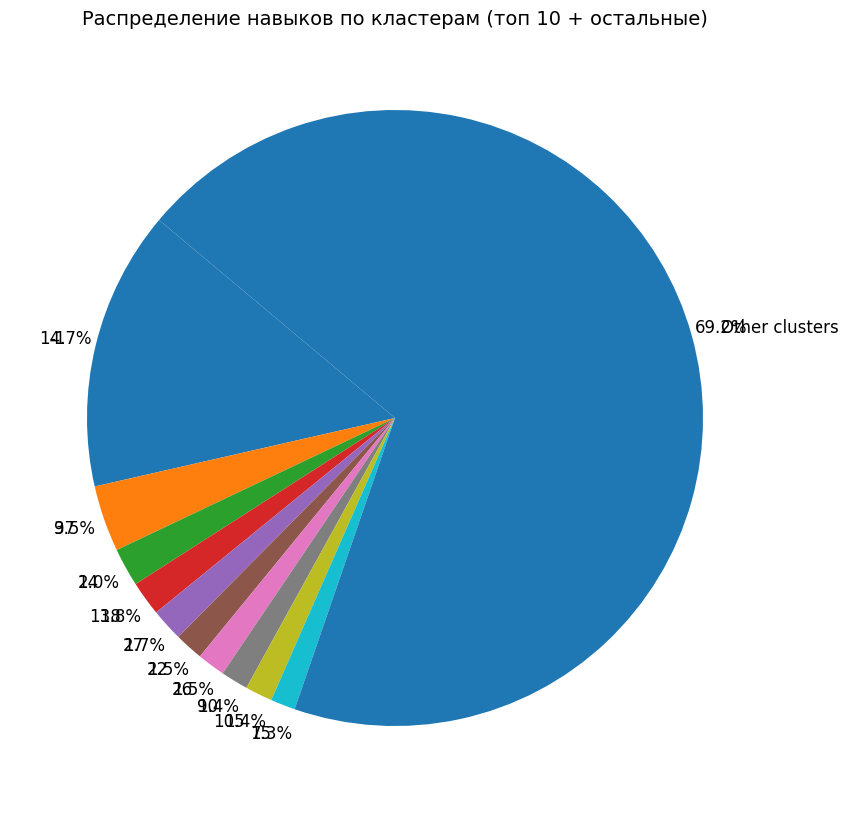

Изначально уникальных навыков: 2770
После кластеризации количество кластеров: 146

Самый большой кластер: -1, количество элементов: 430
Примеры навыков и названия кластера:
                                  role_functions_name  \
6                    Administer and enhance databases   
8   Analysis of technical problems and participati...   
13                              Application Stability   
20  Build smart chunking, indexing, retrieval & re...   
21                              Build user LTV models   

                                         cluster_name  
6                    Administer and enhance databases  
8   Analysis of technical problems and participati...  
13                              Application Stability  
20  Build smart chunking, indexing, retrieval & re...  
21                              Build user LTV models  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1️⃣ Подготовка данных для круговой диаграммы
cluster_counts = df_final['cluster'].value_counts()  # количество элементов по кластерам
top10 = cluster_counts.head(10)
others_sum = cluster_counts.iloc[10:].sum()

# Создаем Series с "остальными" через pd.concat
cluster_counts_plot = pd.concat([top10, pd.Series({'Other clusters': others_sum})])

# 2️⃣ Настройка меток и процентов
labels = cluster_counts_plot.index.astype(str)
sizes = cluster_counts_plot.values
total = sizes.sum()
percentages = [f'{s/total*100:.1f}%' for s in sizes]

# 3️⃣ Круговая диаграмма с процентами снаружи
plt.figure(figsize=(10,10))
wedges, texts = plt.pie(
    sizes, labels=labels, autopct=None, startangle=140, textprops={'fontsize': 12}
)

# Добавляем проценты снаружи
for i, w in enumerate(wedges):
    ang = (w.theta2 + w.theta1)/2.
    x = 1.1 * np.cos(np.deg2rad(ang))
    y = 1.1 * np.sin(np.deg2rad(ang))
    plt.text(x, y, percentages[i], ha='center', va='center', fontsize=12)

plt.title('Распределение навыков по кластерам (топ 10 + остальные)', fontsize=14)
plt.show()

# 4️⃣ Сравнение количества уникальных навыков до и после кластеризации
original_unique_skills = df_final['clean'].nunique()
num_clusters = len(df_final['cluster'].unique())

print(f"Изначально уникальных навыков: {original_unique_skills}")
print(f"После кластеризации количество кластеров: {num_clusters}")

# 5️⃣ Примеры из самого большого кластера
largest_cluster_id = cluster_counts.idxmax()
top5_skills = df_final[df_final['cluster']==largest_cluster_id][['role_functions_name', 'cluster_name']].head(5)
print(f"\nСамый большой кластер: {largest_cluster_id}, количество элементов: {cluster_counts[largest_cluster_id]}")
print("Примеры навыков и названия кластера:")
print(top5_skills)
